In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings

In [63]:
warnings.filterwarnings('ignore')

In [64]:
# Load the data
df = pd.read_csv("../datasets/gender_classification_v7.csv")
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (5001, 8)

First 5 rows:
   long_hair  forehead_width_cm  forehead_height_cm  nose_wide  nose_long  \
0          1               11.8                 6.1          1          0   
1          0               14.0                 5.4          0          0   
2          0               11.8                 6.3          1          1   
3          0               14.4                 6.1          0          1   
4          1               13.5                 5.9          0          0   

   lips_thin  distance_nose_to_lip_long  gender  
0          1                          1    Male  
1          1                          0  Female  
2          1                          1    Male  
3          1                          1    Male  
4          0                          0  Female  


In [65]:
# Check class distribution
print("\nGender distribution:")
print(df['gender'].value_counts())


Gender distribution:
gender
Female    2501
Male      2500
Name: count, dtype: int64


In [66]:
# Drop the gender column for unsupervised analysis
X = df.drop('gender', axis=1)

In [67]:
# ---------- EDA: JUST 2-3 KEY VISUALIZATIONS ----------
plt.figure(figsize=(18, 6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

Text(0.5, 1.0, 'Feature Correlation Matrix')

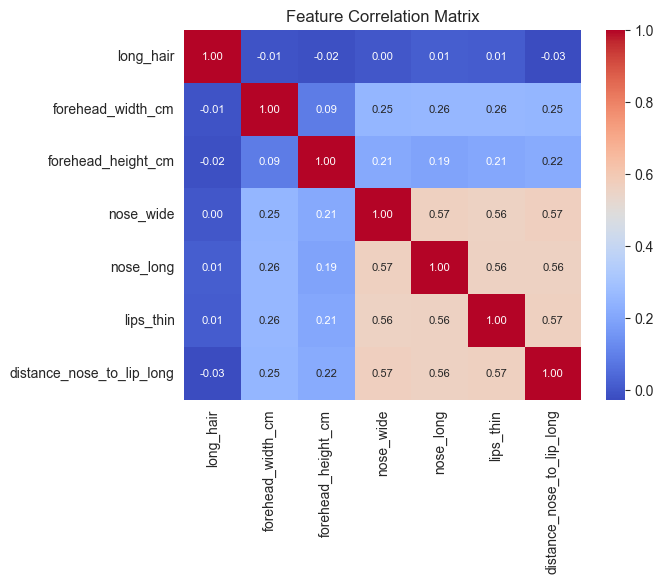

In [91]:
# 1. Correlation heatmap
plt.figure(7.7)
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})
plt.title('Feature Correlation Matrix')

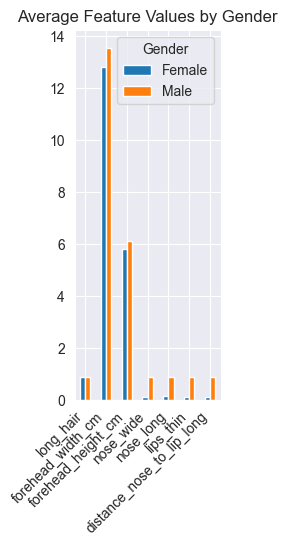

In [92]:
# 2. Feature distributions by gender
plt.subplot(1, 3, 2)
features_mean = df.groupby('gender')[X.columns].mean()
features_mean.T.plot(kind='bar', ax=plt.gca())
plt.title('Average Feature Values by Gender')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')

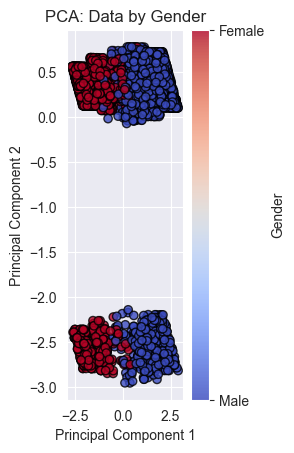

In [93]:
# 3. PCA visualization of the data colored by gender
plt.subplot(1, 3, 3)
# Standardize data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Create gender numeric mapping for coloring
gender_map = {'Male': 0, 'Female': 1}
gender_numeric = df['gender'].map(gender_map)
# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gender_numeric, cmap='coolwarm', alpha=0.8, edgecolor='k')
plt.title('PCA: Data by Gender')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(ticks=[0, 1], label='Gender').set_ticklabels(['Male', 'Female'])

In [71]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [98]:
# ---------- FIND OPTIMAL K ----------
# Prepare to evaluate different K values
K_range = range(2, 11)
distortions = []  # For elbow method
silhouette_scores = []  # For silhouette analysis

In [99]:
for k in K_range:
    # Create and fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Get inertia (sum of squared distances) for elbow method
    distortions.append(kmeans.inertia_)

    # Calculate silhouette score
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

In [100]:
# ---------- VISUALIZE ELBOW METHOD AND SILHOUETTE SCORES ----------
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

Text(3, 22997.245573457698, 'Elbow Point')

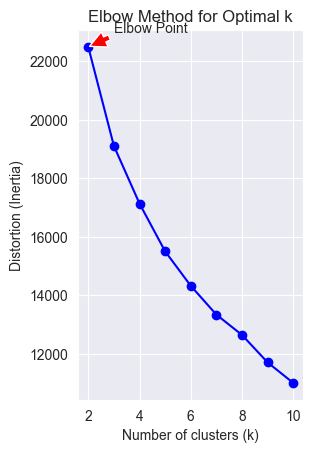

In [101]:
# 1. Elbow Method
plt.subplot(1, 2, 1)
plt.plot(K_range, distortions, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
# Add annotation for the "elbow" point
elbow_point = 2  # Typically k=2 for this dataset, but could be calculated
plt.annotate('Elbow Point', xy=(elbow_point, distortions[elbow_point - 2]),
             xytext=(elbow_point + 1, distortions[elbow_point - 2] + 500),
             arrowprops=dict(facecolor='red', shrink=0.05))

Text(4, 0.3370744764096068, 'Best k=3')

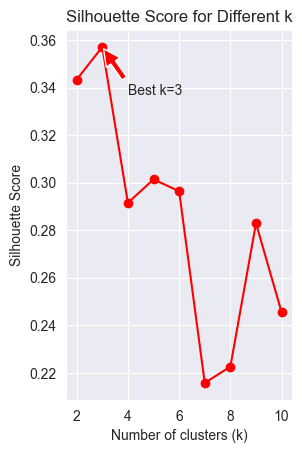

In [102]:
# 2. Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.grid(True)
# Add annotation for the best silhouette score
best_k_silhouette = K_range[np.argmax(silhouette_scores)]
plt.annotate(f'Best k={best_k_silhouette}',
             xy=(best_k_silhouette, silhouette_scores[best_k_silhouette - 2]),
             xytext=(best_k_silhouette + 1, silhouette_scores[best_k_silhouette - 2] - 0.02),
             arrowprops=dict(facecolor='red', shrink=0.05))

In [103]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [104]:
# ---------- APPLY OPTIMAL CLUSTERING AND VISUALIZE RESULTS ----------
# Apply KMeans with the optimal k (usually k=2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

In [105]:
# Add cluster labels to original data
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

In [106]:
# Visualize results
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

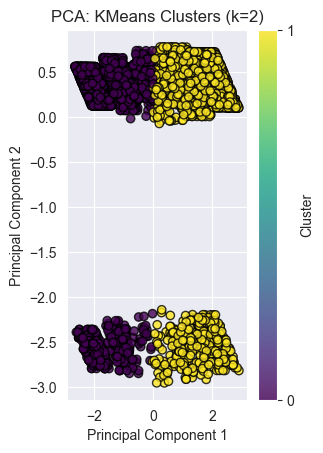

In [107]:
# 1. PCA visualization with clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.8, edgecolor='k')
plt.title(f'PCA: KMeans Clusters (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(ticks=range(optimal_k), label='Cluster').set_ticklabels(range(optimal_k))

Text(321.26767676767673, 0.5, 'Cluster')

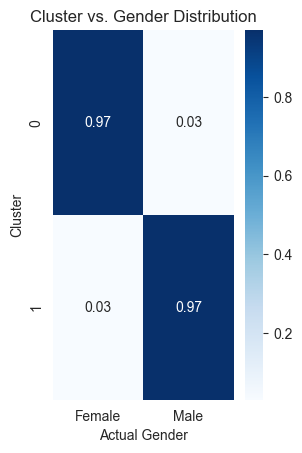

In [108]:
# 2. Confusion matrix between clusters and gender
plt.subplot(1, 2, 2)
confusion_df = pd.crosstab(df_clustered['cluster'], df['gender'], normalize='index')
sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='.2f')
plt.title('Cluster vs. Gender Distribution')
plt.xlabel('Actual Gender')
plt.ylabel('Cluster')

In [109]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [110]:
# Calculate and print accuracy
majority_gender = {}
for cluster in range(optimal_k):
    if confusion_df.loc[cluster, 'Male'] > confusion_df.loc[cluster, 'Female']:
        majority_gender[cluster] = 'Male'
    else:
        majority_gender[cluster] = 'Female'

In [111]:
df_clustered['predicted_gender'] = df_clustered['cluster'].map(majority_gender)
accuracy = (df_clustered['predicted_gender'] == df['gender']).mean()
print(f"\nClustering accuracy when mapped to gender: {accuracy:.4f}")
print("\nCluster to gender mapping:")
for cluster, gender in majority_gender.items():
    print(f"Cluster {cluster} -> {gender} ({confusion_df.loc[cluster, gender] * 100:.1f}%)")


Clustering accuracy when mapped to gender: 0.9682

Cluster to gender mapping:
Cluster 0 -> Female (96.7%)
Cluster 1 -> Male (97.0%)
